In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [54]:
df = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [55]:
# Check numerical columns (assuming all are numerical)
print(df.dtypes)

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


*# Separate features (X) and target (y)*

In [56]:

X = df.drop(columns=["loan_status"])
y = df["loan_status"]

*Define numerical and categorical columns*

In [57]:

numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

*Preprocessing pipeline*

In [58]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [59]:
# Exploratory Data Analysis
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())


Dataset shape: (32581, 12)

First 5 rows:
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59               

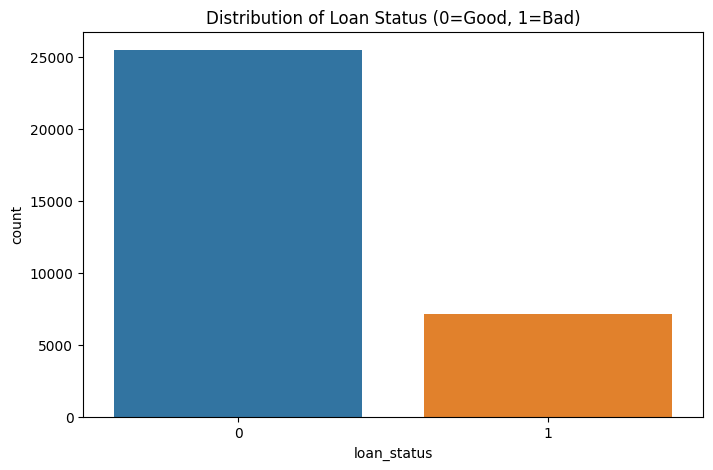

In [60]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status (0=Good, 1=Bad)')
plt.show()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

In [62]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss")
}

In [69]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.exceptions import NotFittedError

# Train and evaluate models
for name, model in models.items():
    try:
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Get probabilities (handle models that don't have predict_proba)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Scale to [0,1]
        
        # Print performance metrics
        print(f"\n{name} Performance:")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
        
        # For models that support feature importance
        if hasattr(model, "feature_importances_"):
            print("\nTop 5 Important Features:")
            importances = model.feature_importances_
            feature_names = preprocessor.get_feature_names_out()
            for i in importances.argsort()[-5:][::-1]:
                print(f"{feature_names[i]}: {importances[i]:.4f}")
                
    except NotFittedError as e:
        print(f"Error fitting {name}: {str(e)}")
    except Exception as e:
        print(f"Unexpected error with {name}: {str(e)}")

Unexpected error with Logistic Regression: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Unexpected error with Random Forest: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternativ

In [70]:
# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_features)

In [71]:
# Plot XGBoost feature importance
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

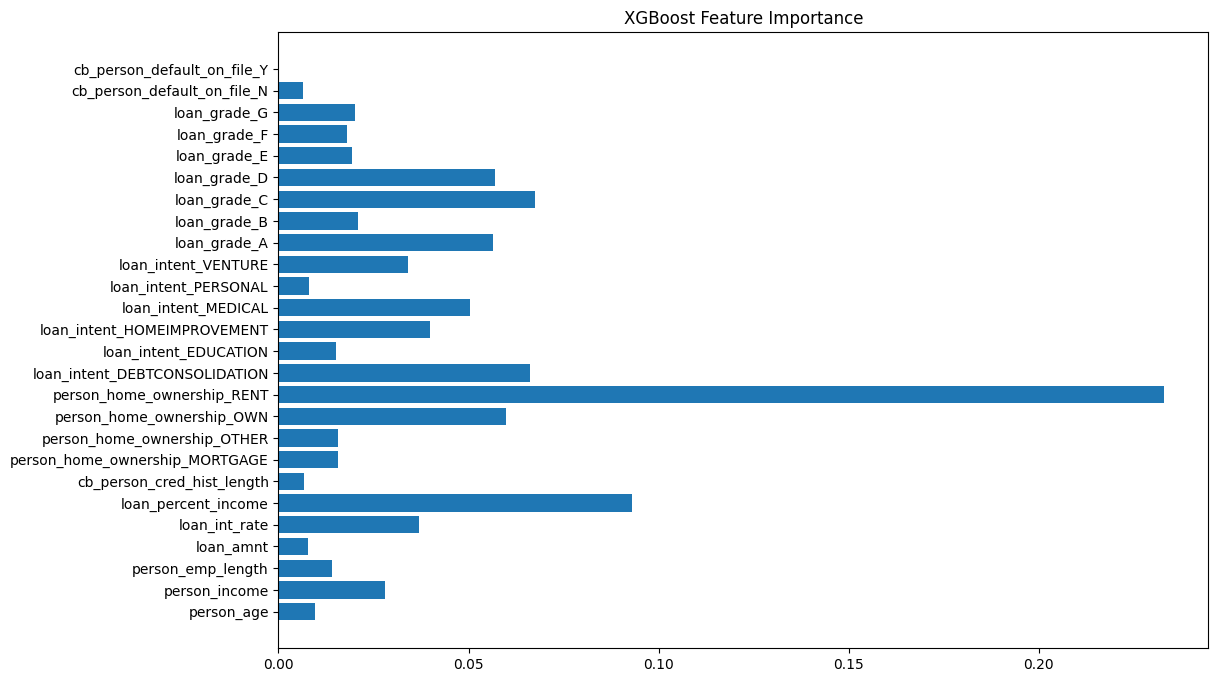

In [72]:
plt.figure(figsize=(12, 8))
plt.barh(all_features, xgb_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.show()

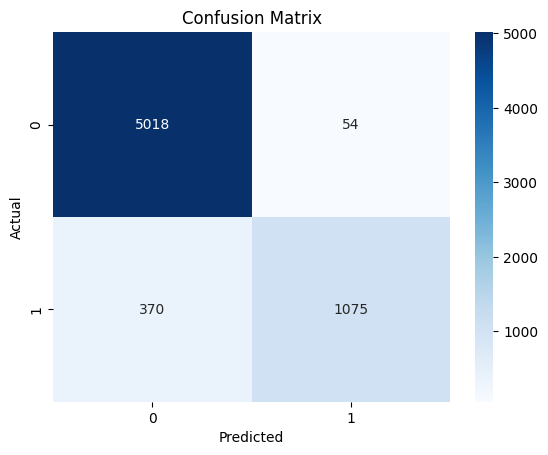

In [73]:
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()